In [1]:
import pathlib
import rasterio
import numpy as np
import pandas as pd
import torch
from PIL import Image
# Written Utils Functions
from Utils.utils import build_embedding_model, compute_image_embeddings
from Utils.utils import compute_tabular_features, combine_features
# Writtent Model Functions
from Utils.computation import compute_pca_components
from Utils.computation import estimate_treatment_effect_tabular 
from Utils.computation import estimate_treatment_effect_with_embeddings
from Utils.computation import evaluate_ite, get_train_test_indices

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Collect file paths
COV_DIR = pathlib.Path('/Users/sayedmorteza/Library/CloudStorage/Box-Box/Hetwet_Data')
DATA_DIR = pathlib.Path('/Users/sayedmorteza/Library/CloudStorage/Box-Box/Caltech Research/Scripts/ImageTRT/Synthetic Data Generation/Results')


folders = {
    'wet': DATA_DIR / 'Treatment',
    'dem': COV_DIR / 'DEM',
    'cap': COV_DIR / 'CAPITAL_1996',
    'outcome': DATA_DIR / 'Outcome_Post',
    'ite': DATA_DIR / 'ITE_TOTAL'
}


scene_ids = [str(i) for i in range(1, 3566)]

In [3]:
# Tabular features
tab_df = compute_tabular_features(folders, scene_ids)
tab_df.head()
tab_df.to_csv('tabular_features.csv', index=False)

Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.


Saved features to: /Users/sayedmorteza/Library/CloudStorage/Box-Box/Caltech Research/Scripts/ImageTRT/Model/features.csv


In [5]:
tab_df.describe()

,wet_mean,wet_std,dem_mean,dem_std,cap_mean,cap_std,outcome_mean,outcome_std,ite_mean,ite_std
count,3565.000000,3565.000000,3565.000000,3565.000000,3.565000e+03,3.565000e+03,3565.000000,3565.000000,3565.000000,3565.000000
mean,0.008493,0.037655,-433.918692,216.401709,4.197241e+04,2.520522e+05,3.747508,0.715218,0.000519,0.001882
std,0.029382,0.078367,1861.773938,907.998179,1.721724e+05,1.280287e+06,1.121531,1.639506,0.001915,0.005024
min,0.000000,0.000000,-9999.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.727104,0.834537,0.000000e+00,0.000000e+00,3.703125,0.390312,0.000000,0.000000
50%,0.000000,0.000000,9.806548,2.776222,2.873736e+03,2.000996e+04,3.781250,0.441665,0.000000,0.000000
75%,0.001251,0.035350,30.674374,7.810327,2.278676e+04,7.562379e+04,3.875000,0.474959,0.000000,0.000000
max,0.418045,0.493238,103.384105,4999.444138,6.145465e+06,3.960960e+07,33.647849,49.727313,0.027906,0.034863


In [3]:
# Embeddings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = build_embedding_model(
    device=device,
    model_type='resnet18', 
    conv_layer=4             
)

# Compute image embeddings for each variable
# for var in folders:
#     _ = compute_image_embeddings(
#         folders=folders,
#         scene_ids=scene_ids,
#         var=var,
#         model=model,
#         device=device,
#         img_size=256,
#     )

# Compute image embeddings for only wetland
var = 'wet'
_ = compute_image_embeddings(
    folders=folders,
    scene_ids=scene_ids,
    var=var,
    model=model,
    device=device,
    img_size=256,
)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
Embedding wet scenes: 100%|██████████| 3565/3565 [27:16<00:00,  2.18it/s]


Saved embeddings to: /Users/sayedmorteza/Library/CloudStorage/Box-Box/Caltech Research/Scripts/ImageTRT/Model/wet_embeddings.csv


In [4]:
# Get pca features
pca_wet = compute_pca_components('wet_embeddings.csv', n_components=10)
# pca_dem = compute_pca_components('dem_embeddings.csv', n_components=2)
# pca_cap = compute_pca_components('cap_embeddings.csv', n_components=2)
# pca_claims_96 = compute_pca_components('claims_96_embeddings.csv', n_components=2)

pca_wet.to_csv("wet_pca10.csv")

In [ ]:
# combine features
combined_df = combine_features(
    tab_df,
    pca_wet=pca_wet,
    pca_dem=pca_dem,
    pca_cap=pca_cap,
    pca_claims_96=pca_claims_96
)

In [6]:
tab_df.head()

,scene_id,wet_mean,wet_std,dem_mean,dem_std,cap_mean,cap_std,outcome_mean,outcome_std,ite_mean,ite_std
0,1,0.0,0.0,64.378952,22.386531,0.0,0.0,3.781250,0.413399,0.0,0.0
1,2,0.0,0.0,94.023680,23.789066,0.0,0.0,3.859375,0.347634,0.0,0.0
2,3,0.0,0.0,103.384105,15.987604,0.0,0.0,3.796875,0.402325,0.0,0.0
3,4,0.0,0.0,88.248975,15.052856,0.0,0.0,3.875000,0.330719,0.0,0.0
4,5,0.0,0.0,86.249280,11.162309,0.0,0.0,3.812500,0.390312,0.0,0.0


In [4]:
# load tables
tab_df     = pd.read_csv('tabular_features.csv')
pca_wet    = pd.read_csv('wet_pca10.csv')

# outcome variable
tab_df['outcome'] = tab_df['outcome_mean']

# pick outcome & features
OUTCOME = 'ite_mean'
TREAT   = 'wet_mean'
# COVS    = [c for c in tab_df.columns 
#           if c not in ('scene_id', OUTCOME, 'wet_mean', 'outcome', 'claims_16_mean', 'claims_96_mean')]
COVS = ['dem_mean', 'cap_mean', 'dem_std', 'cap_std']

# merge PCA back onto tab_df
df = tab_df.merge(pca_wet,  on='scene_id', how='left')

# split once
train_idx, test_idx = get_train_test_indices(tab_df, test_size=0.2, random_state=42)

In [5]:
# tabular-only
cate_tab, ate_tab, model_tab = estimate_treatment_effect_tabular(
    df=df,
    train_idx=train_idx,
    test_idx=test_idx,
    outcome_col=OUTCOME,
    treatment_col=TREAT,
    covariate_cols=COVS
)

In [4]:
# include image embeddings in the treatment
PCA_COLS = [f'PC{i+1}' for i in range(10)]

cate_img, ate_img, model_img = estimate_treatment_effect_with_embeddings(
    df,
    train_idx,
    test_idx,
    outcome_col=OUTCOME,
    treatment_col=PCA_COLS,
    covariate_cols=COVS
)

print("Tabular ATE (train/test):", ate_tab)
print("Image‐augmented ATE (train/test):", ate_img)

# ompare out‐of‐sample CATE distributions
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(cate_tab.query("dataset=='test'")['CATE'], label='tabular')
sns.kdeplot(cate_img.query("dataset=='test'")['CATE_wet'], label='with embeddings')
plt.legend(); plt.title("Test‐set CATE distributions")
plt.show()

A scalar was specified but there are multiple treatments; the same value will be used for each treatment.  Consider specifyingall treatments, or using the const_marginal_effect method.
A scalar was specified but there are multiple treatments; the same value will be used for each treatment.  Consider specifyingall treatments, or using the const_marginal_effect method.
A scalar was specified but there are multiple treatments; the same value will be used for each treatment.  Consider specifyingall treatments, or using the const_marginal_effect method.


IndexError: invalid index to scalar variable.

In [6]:
# Actual ITE
cate_true = tab_df[['scene_id', 'ite_mean']]

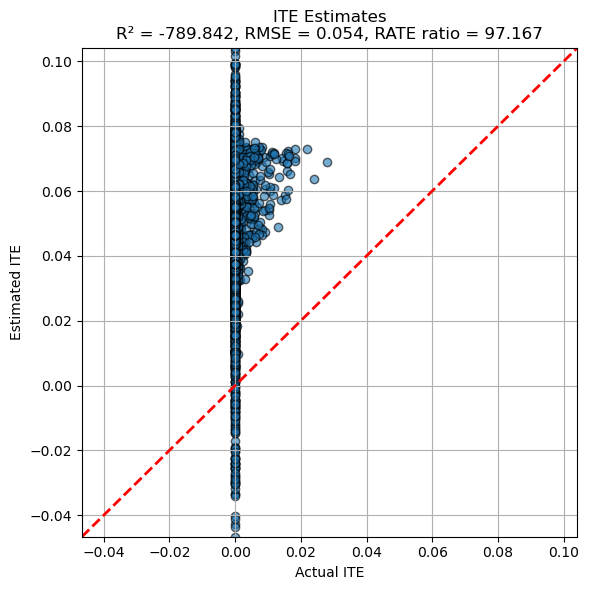

Saved histograms to:
  results/ite_plots/hist_actual_ite.png
  results/ite_plots/hist_estimated_ite.png
{'r2': -789.8421587103322, 'rmse': 0.05385770552831608, 'rate_ratio': 97.16689784155963}


In [7]:
# evaluating ITE with the actual data for tabular
metrics = evaluate_ite(
    cate_true,
    cate_tab,
    id_col="scene_id",
    actual_col="ite_mean",
    estimated_col="CATE",
    output_dir="results/ite_plots"
)
print(metrics)

In [ ]:
# evaluating ITE with the actual data for image
metrics = evaluate_ite(
    cate_true,
    cate_img,
    id_col="scene_id",
    actual_col="actual_ite",
    estimated_col="CATE_wet",
    output_dir="results/ite_plots"
)
print(metrics)

In [11]:
PCA_COLS = [f'PC{i+1}' for i in range(10)]

In [12]:
outcome_col=OUTCOME
treatment_col=PCA_COLS
covariate_cols=COVS


In [13]:
df2 = df.copy()
df2['T_vec'] = df2[treatment_col].values.tolist()


In [15]:
train = df2.loc[train_idx]
test  = df2.loc[test_idx]

In [16]:
X_tr = train[covariate_cols].values
T_tr = np.vstack(train['T_vec'].values)
Y_tr = train[outcome_col].values

X_te = test[covariate_cols].values
T_te = np.vstack(test['T_vec'].values)
Y_te = test[outcome_col].values

In [19]:
from econml.dml import CausalForestDML

# Fit model
cf = CausalForestDML(
    n_estimators=100,
    random_state=42,
)
cf.fit(Y_tr, T_tr, X=X_tr)


In [20]:
cate_tr = cf.effect(X_tr)
cate_te = cf.effect(X_te)

A scalar was specified but there are multiple treatments; the same value will be used for each treatment.  Consider specifyingall treatments, or using the const_marginal_effect method.
A scalar was specified but there are multiple treatments; the same value will be used for each treatment.  Consider specifyingall treatments, or using the const_marginal_effect method.


In [26]:
cate_tr = cf.const_marginal_effect(X_tr)
cate_te = cf.const_marginal_effect(X_te)

In [30]:
cf.const_marginal_ate(X_te)

array([-0.87009908,  0.45176168,  2.47818956,  1.22641501,  1.37732458,
       -0.27319716,  0.42484804, -0.09470584,  1.41985507, -0.34403419])

In [40]:
cf.const_marginal_ate_inference(X_te)

,mean_point,stderr_mean,zstat,pvalue,ci_mean_lower,ci_mean_upper
T0,-0.87,9.829,-0.089,0.929,-20.135,18.395
T1,0.452,12.596,0.036,0.971,-24.237,25.14
T2,2.478,14.438,0.172,0.864,-25.82,30.776
T3,1.226,11.065,0.111,0.912,-20.461,22.914
T4,1.377,20.281,0.068,0.946,-38.372,41.127
T5,-0.273,21.479,-0.013,0.99,-42.371,41.824
T6,0.425,18.004,0.024,0.981,-34.863,35.713
T7,-0.095,6.195,-0.015,0.988,-12.237,12.048
T8,1.42,13.116,0.108,0.914,-24.287,27.127
T9,-0.344,21.995,-0.016,0.988,-43.454,42.766


In [32]:
df['ite_mean'].describe()

count    3565.000000
mean        0.000519
std         0.001915
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.027906
Name: ite_mean, dtype: float64

In [31]:
ate_tab

{'ate_train': 0.2845239037618157, 'ate_test': -0.03915689854283351}

In [21]:
cate_tr

array([-19.39055346,  -0.62530468,  -0.12296818, ...,   2.74085379,
         0.19379128,  22.74688646])

In [ ]:

# Predict CATEs


# Predict ATEs using proper baseline for multivariate treatment
baseline = np.zeros(T_tr.shape[1])
ate_tr = cf.ate(X_tr, T0=baseline)
ate_te = cf.ate(X_te, T0=baseline)

# Collect results
df_tr = pd.DataFrame({
    'scene_id': train['scene_id'].values,
    'dataset': 'train',
    'CATE_wet': cate_tr
})
df_te = pd.DataFrame({
    'scene_id': test['scene_id'].values,
    'dataset': 'test',
    'CATE_wet': cate_te
})

cate_df = pd.concat([df_tr, df_te], ignore_index=True)
ate_dict = {'ate_train': ate_tr, 'ate_test': ate_te}
